In [ ]:
import re
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import tempfile
import urllib.request
import zipfile

In [ ]:
file_path = "../EDA/regional_combined_centroids.csv"
df = pd.read_csv(file_path)

df.head()

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,GEOID,latitude,longitude,state
0,13001950100,Georgia,Appling County,0,3190,1270,0,34,1.07,0,...,0,5,86,104,68,164,13001950100,31.878017,-82.270221,GA
1,13001950400,Georgia,Appling County,0,1476,606,0,0,0.00,1,...,0,10,46,38,38,96,13001950400,31.665217,-82.190726,GA
2,13001950500,Georgia,Appling County,0,3864,1493,0,0,0.00,0,...,11,36,284,394,49,246,13001950500,31.694233,-82.380489,GA
3,13003960100,Georgia,Atkinson County,0,2077,770,0,0,0.00,1,...,3,18,309,387,67,200,13003960100,31.324885,-83.024239,GA
4,13003960200,Georgia,Atkinson County,0,5053,1763,0,20,0.40,0,...,21,16,1121,1437,124,290,13003960200,31.285147,-82.879234,GA


In [ ]:
print("Shape:", df.shape)

Shape: (7121, 151)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Columns: 151 entries, CensusTract to state
dtypes: float64(115), int64(33), object(3)
memory usage: 8.2+ MB


In [ ]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

lalowi20              7065
laseniors20share      7065
lawhite20share        7065
lablack20             7065
lablack20share        7065
                      ... 
laomultirhalfshare      45
lahisphalf              45
lahisphalfshare         45
lahunvhalf              45
lasnaphalf              45
Length: 111, dtype: int64


In [ ]:
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
CensusTract,7121.0,2.406932e+10,1.645696e+10,1.001020e+09,1.306703e+10,2.120796e+10,4.504500e+10,4.718903e+10
Urban,7121.0,5.996349e-01,4.900067e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Pop2010,7121.0,3.616327e+03,1.399714e+03,1.000000e+00,2.569000e+03,3.569000e+03,4.580000e+03,1.094500e+04
OHU2010,7121.0,1.403366e+03,5.439051e+02,0.000000e+00,1.002000e+03,1.390000e+03,1.780000e+03,3.688000e+03
GroupQuartersFlag,7121.0,7.442775e-03,8.595590e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...
TractHUNV,7121.0,1.043939e+02,9.861067e+01,0.000000e+00,3.600000e+01,7.700000e+01,1.440000e+02,1.117000e+03
TractSNAP,7121.0,2.189584e+02,1.593869e+02,0.000000e+00,1.020000e+02,1.880000e+02,3.050000e+02,1.276000e+03
GEOID,7121.0,2.406932e+10,1.645696e+10,1.001020e+09,1.306703e+10,2.120796e+10,4.504500e+10,4.718903e+10
latitude,7121.0,3.413292e+01,2.253994e+00,2.918312e+01,3.251074e+01,3.406278e+01,3.582430e+01,3.911587e+01


In [ ]:
print(df['Urban'].value_counts())
print(df['State'].value_counts().head(10))

Urban
1    4270
0    2851
Name: count, dtype: int64
State
Tennessee         1284
Georgia           1248
Alabama            933
Kentucky           916
South Carolina     883
Louisiana          856
Arkansas           547
Mississippi        454
Name: count, dtype: int64


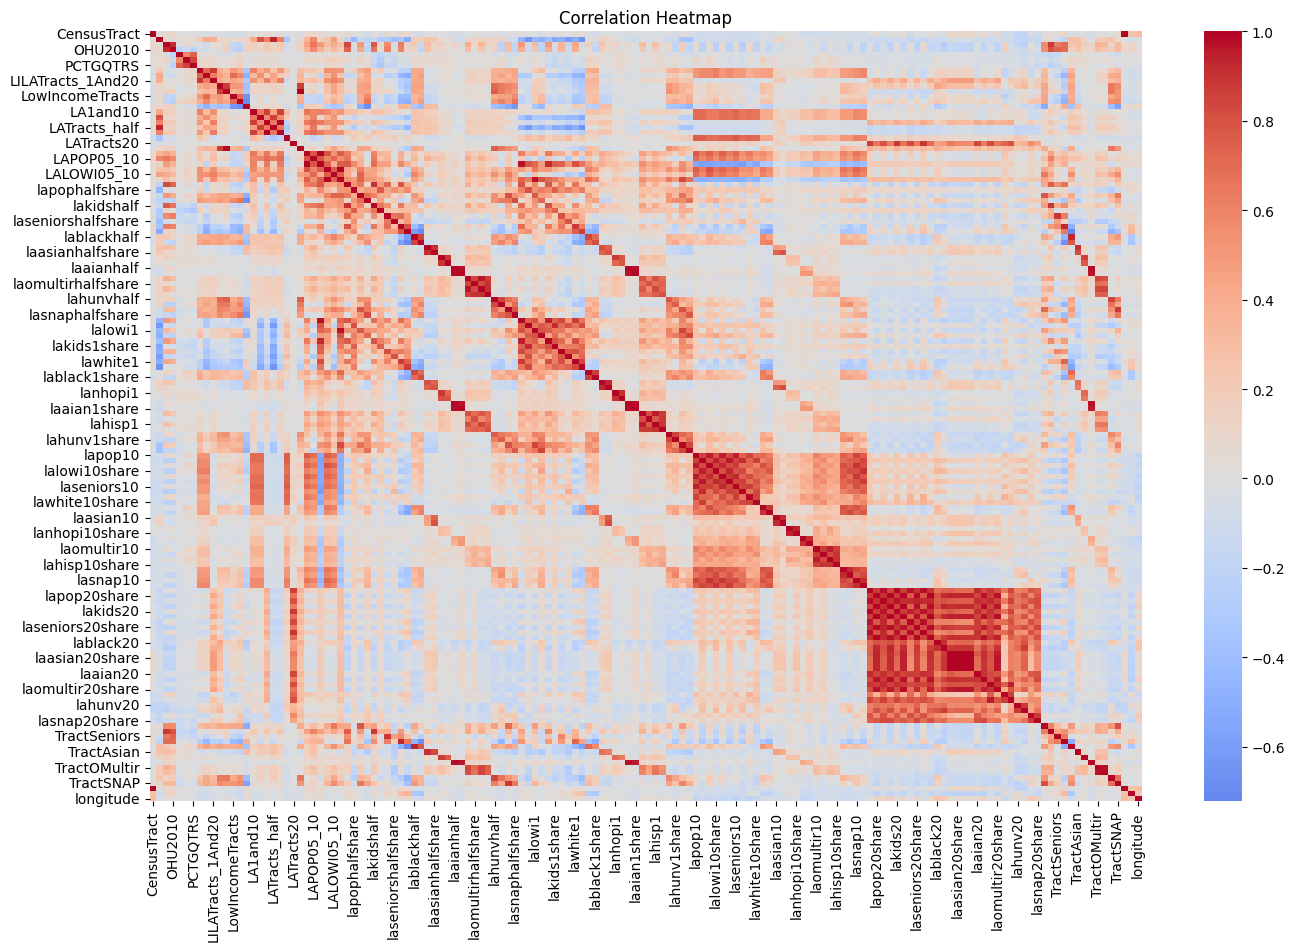

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

Since we are looking at food deserts lets explore LILA (Low Income Low Access), TractHUNV, TractSNAP, PovertyRate, MedianFamilyIncome

In [ ]:
columns_of_interest = [
    'LILATracts_1And10', 'LILATracts_halfAnd10', 'LILATracts_1And20',
    'TractHUNV', 'PovertyRate', 'MedianFamilyIncome'
]

df[columns_of_interest].describe()

,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,TractHUNV,PovertyRate,MedianFamilyIncome
count,7121.000000,7121.000000,7121.000000,7121.000000,7121.000000,7046.000000
mean,0.219492,0.348968,0.177644,104.393905,20.054318,60593.496878
std,0.413931,0.476677,0.382239,98.610668,12.825492,28572.457048
min,0.000000,0.000000,0.000000,0.000000,0.000000,9779.000000
25%,0.000000,0.000000,0.000000,36.000000,10.600000,42409.500000
50%,0.000000,0.000000,0.000000,77.000000,17.900000,54488.500000
75%,0.000000,1.000000,0.000000,144.000000,27.000000,70977.000000
max,1.000000,1.000000,1.000000,1117.000000,100.000000,250001.000000


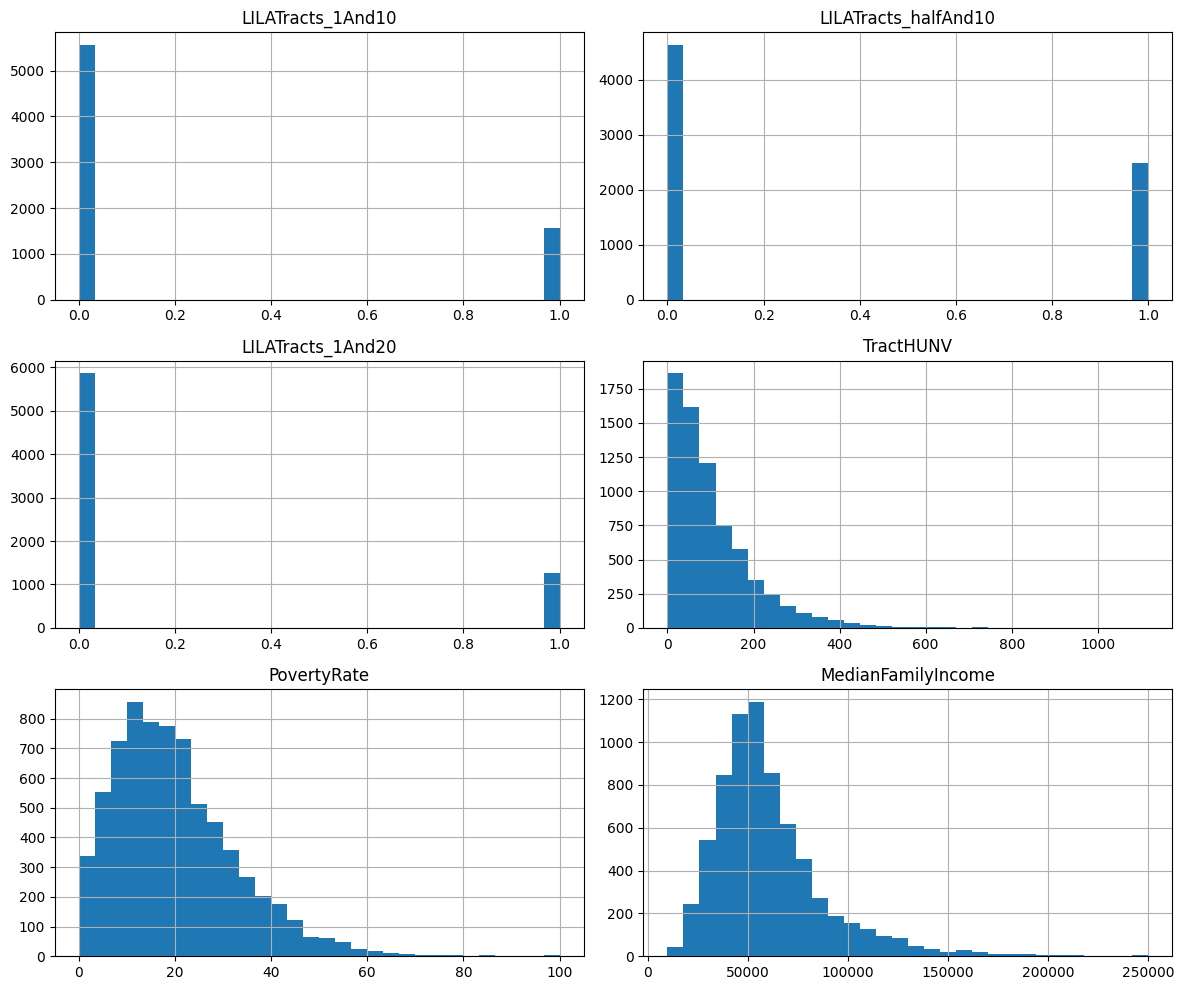

In [ ]:
df[columns_of_interest].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

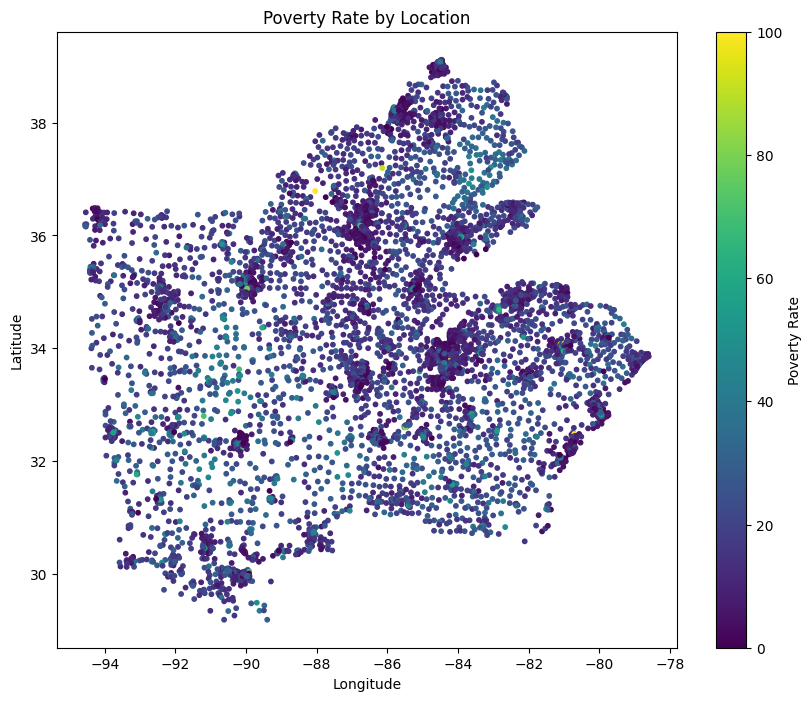

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], c=df['PovertyRate'], cmap='viridis', s=10)
plt.colorbar(label='Poverty Rate')
plt.title('Poverty Rate by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Urban vs Rural Comparision

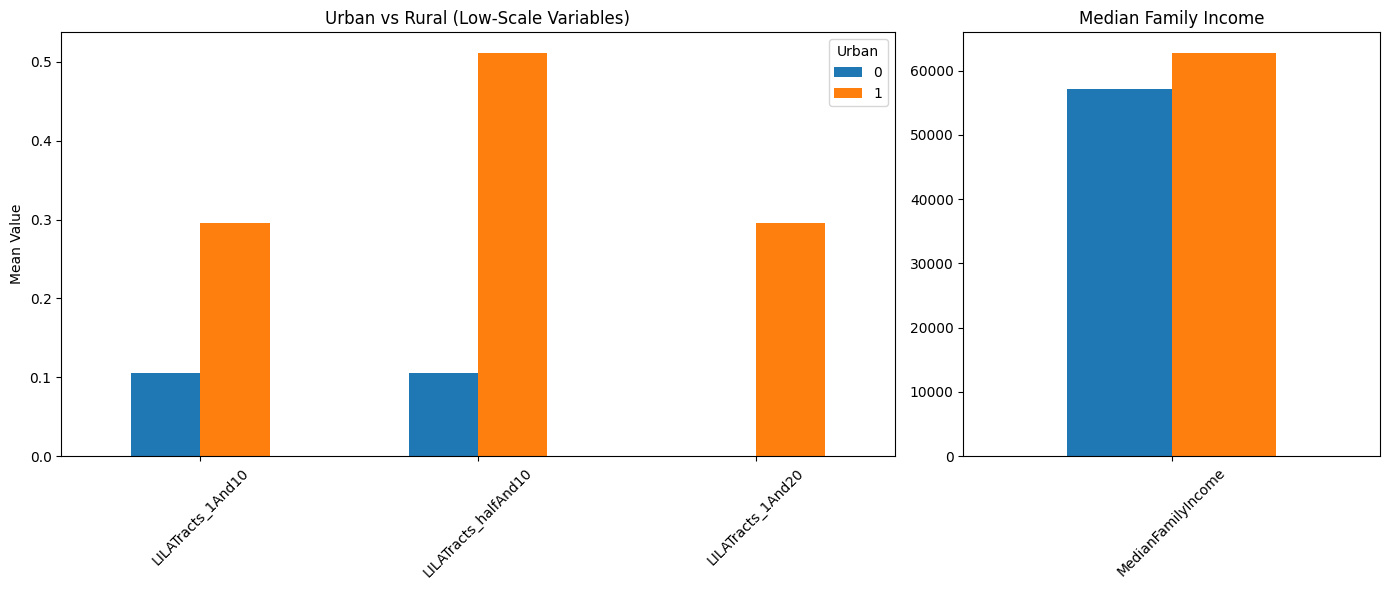

In [ ]:
low_scale_cols = ['LILATracts_1And10', 'LILATracts_halfAnd10', 'LILATracts_1And20']
high_scale_col = ['MedianFamilyIncome']

group_cols = low_scale_cols + high_scale_col
urban_grouped = df.groupby('Urban')[group_cols].mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

urban_grouped[low_scale_cols].T.plot(kind='bar', ax=axes[0])
axes[0].set_title("Urban vs Rural (Low-Scale Variables)")
axes[0].set_ylabel("Mean Value")
axes[0].tick_params(axis='x', rotation=45)

urban_grouped[high_scale_col].T.plot(kind='bar', ax=axes[1], legend=False)
axes[1].set_title("Median Family Income")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


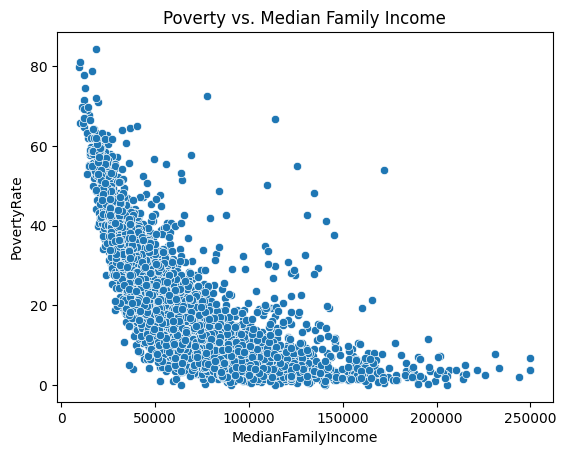

In [ ]:
sns.scatterplot(data=df, x='MedianFamilyIncome', y='PovertyRate')
plt.title('Poverty vs. Median Family Income')
plt.show()

Handling Missing Values

In [ ]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

# Fill numeric columns with median
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Drop rows missing lat/long (needed for geospatial plots)
df = df.dropna(subset=['latitude', 'longitude'])


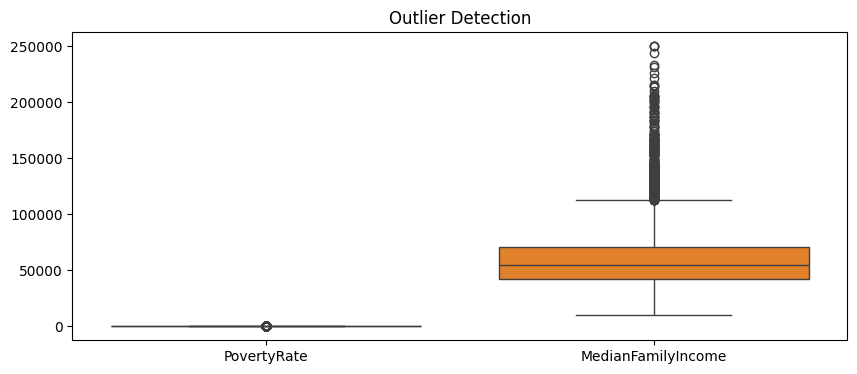

In [ ]:
# Boxplot : check for outliers
plt.figure(figsize=(10, 4))
sns.boxplot(data=df[['PovertyRate', 'MedianFamilyIncome']])
plt.title("Outlier Detection")
plt.show()

# cap outliers using IQR
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

df['PovertyRate'] = cap_outliers(df['PovertyRate'])
df['MedianFamilyIncome'] = cap_outliers(df['MedianFamilyIncome'])


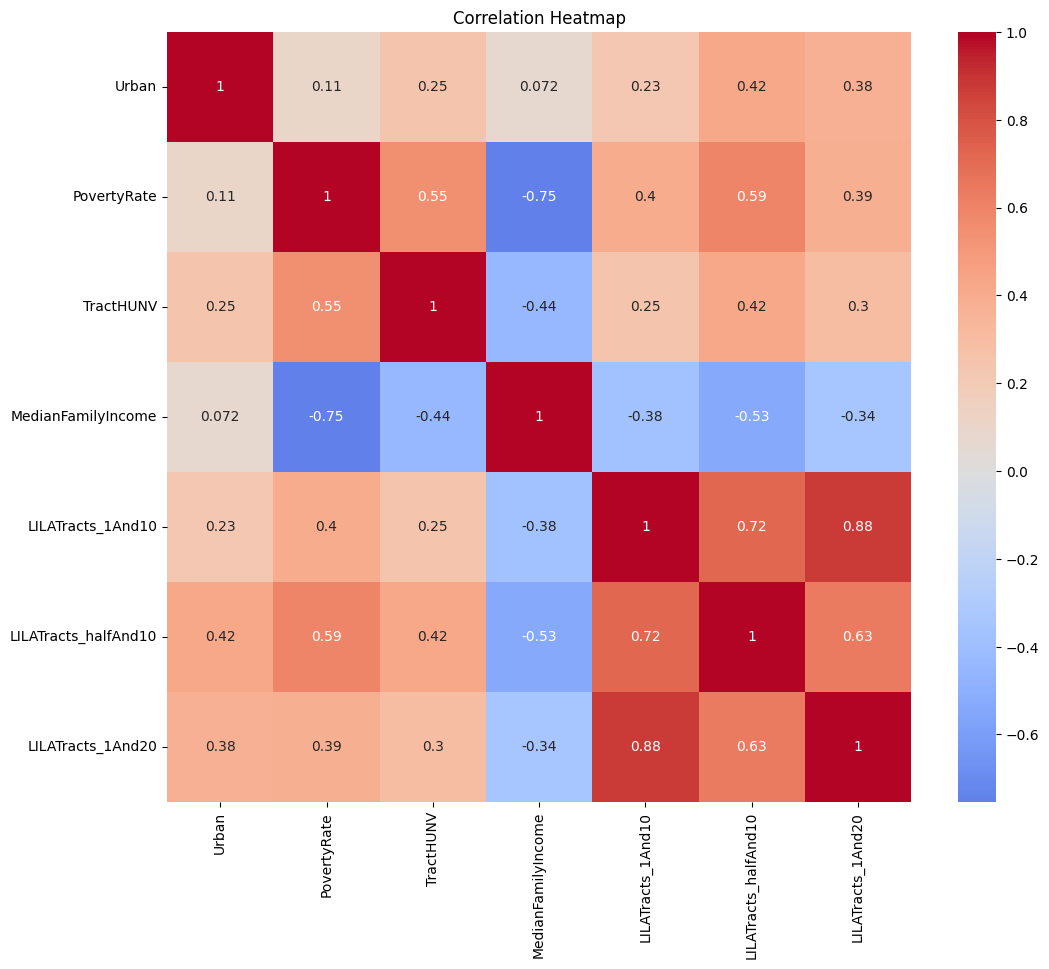

In [ ]:
# New correlation map
plt.figure(figsize=(12, 10))
sns.heatmap(df[selected_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

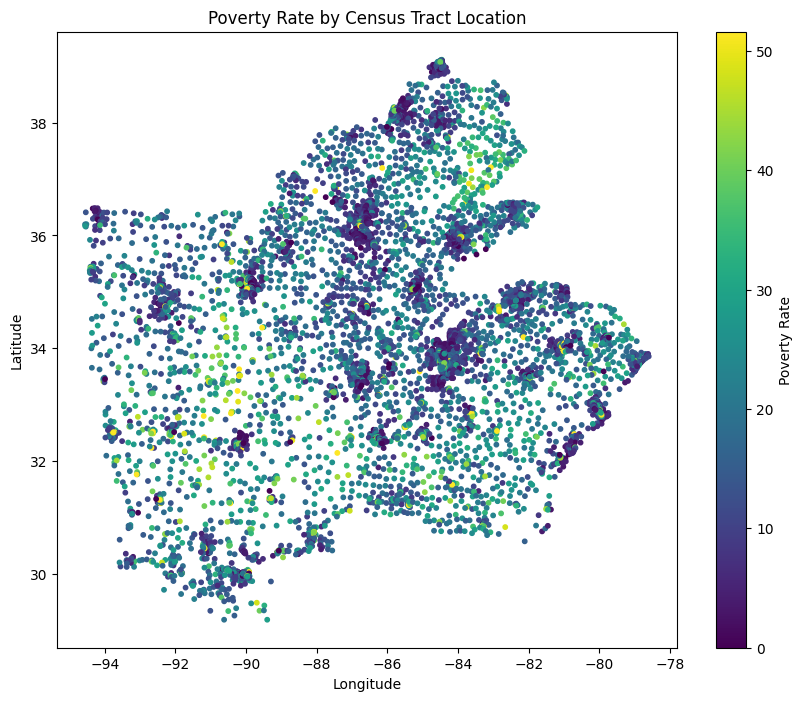

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], c=df['PovertyRate'], cmap='viridis', s=10)
plt.colorbar(label='Poverty Rate')
plt.title('Poverty Rate by Census Tract Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()